In [150]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from glob import glob

import scipy.stats as stats

import statsmodels.api as sm 
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [151]:
dir_plots = './plots/'
dir_file = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'

all_files = glob(f"{dir_file}*.dta")
easy_files = glob(f"{rel_data_dir_easy}*.dta")

df_easy = pd.read_stata(easy_files[0])
df_easy = df_easy[df_easy['wave'] == 8]
df_acc_day = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_gv_accelerometer_day.dta'))
df_ph = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_ph.dta'))
df_br = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_br.dta'))


In [152]:
df1 = df_acc_day[["mergeid", "measurementday", "GGIR_mean_ENMO_day", "GGIR_N_valid_hours_day", "OxCGRT_stay_at_home", "OxCGRT_stringency_index"]].copy()
df1.drop(df1.loc[df1['measurementday'] > 7].index, inplace=True)
df1.drop(df1.loc[df1['GGIR_N_valid_hours_day'] < 16].index, inplace=True)
df2 = df_ph[["mergeid", 'ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3']].copy()
df3 = df_br[["mergeid", 'br015_', 'br016_']].copy()
df4 = df_easy[["mergeid", "female", "age", "bmi"]].copy()

In [153]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [154]:
df = df1.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df2[get_common_columns(df2, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df3[get_common_columns(df3, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df4[get_common_columns(df4, df)], right_on=['mergeid'], how='left')

In [155]:
def map_selected_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -1,
            1:1,
            0:0,
            -1:-1,
        })
    return df
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])

def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_bmi_num(df)
df.drop(df.loc[df['bmi'] < 15].index, inplace=True)

def map_freq_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            'More than once a week': 1,
            'Once a week': 2,
            'One to three times a month': 3,
            'Hardly ever, or never': 4,
            "Don't know": -1,
            'Refusal' : -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_freq_num(df, ['br015_', 'br016_']) 

df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)

In [156]:
df['Hypertension'] = pd.to_numeric(df['ph006d2'])
df['Diabetes'] = pd.to_numeric(df['ph006d5'])
df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))

In [157]:
df['d1'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d3'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d4'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d5'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d6'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['d7'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['control'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['disease']  = df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)

In [158]:
df['activity'] = 2*(4-df['br015_']) + (4-df['br016_'])

In [159]:
from matplotlib import cm
def qqplot(x, y,palette= cm.viridis, ax=None, *args, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    sns.scatterplot(x=xr, y=yr, ax=ax, edgecolor="none", palette=palette, *args, **kwargs)

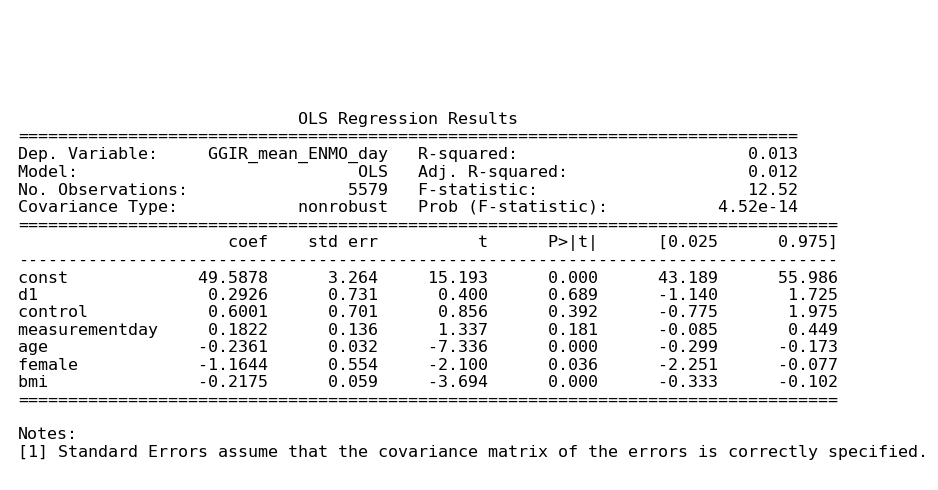

In [160]:
YVar = df["GGIR_mean_ENMO_day"] #dependent

XVar = df[["d1", "control", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day - Hypertension')

In [161]:
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['control'] = np.where((df['Diabetes'] == 0), int(1), int(0))

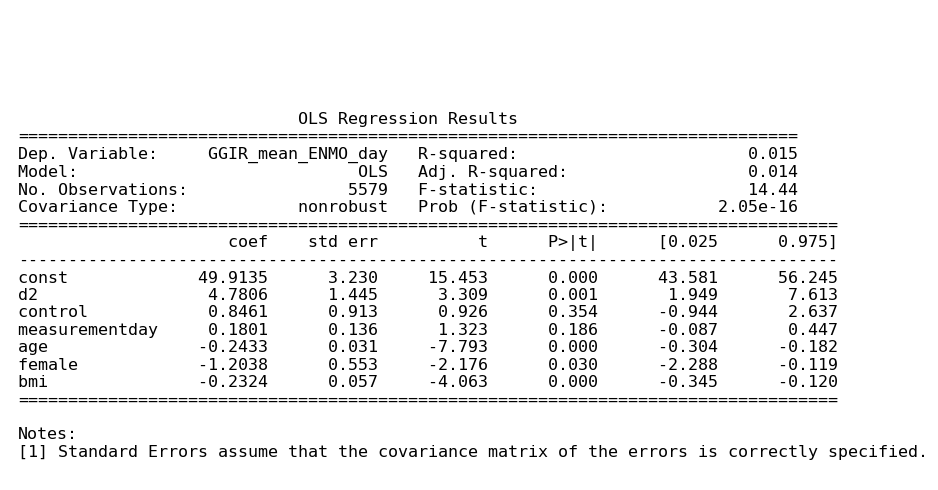

In [162]:
XVar = df[["d2", "control", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day - Diabetes')

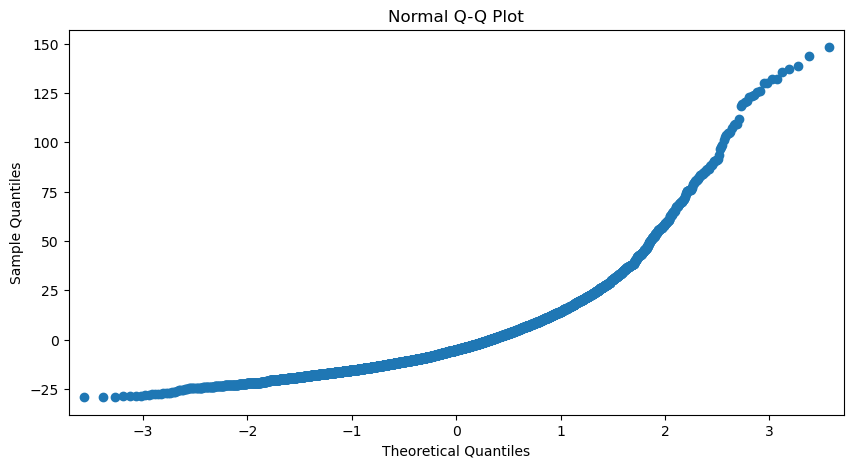

In [163]:
residuals = model.resid
sm.qqplot(residuals)
plt.title("Normal Q-Q Plot")
plt.show()

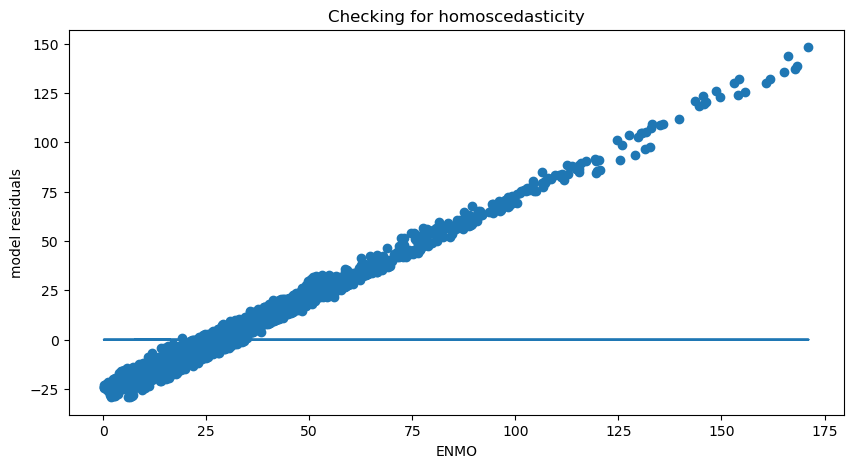

In [164]:
plt.scatter(YVar, residuals)
plt.xlabel("ENMO")
plt.ylabel("model residuals")
plt.title("Checking for homoscedasticity")
plt.plot(YVar, [0]*len(YVar))

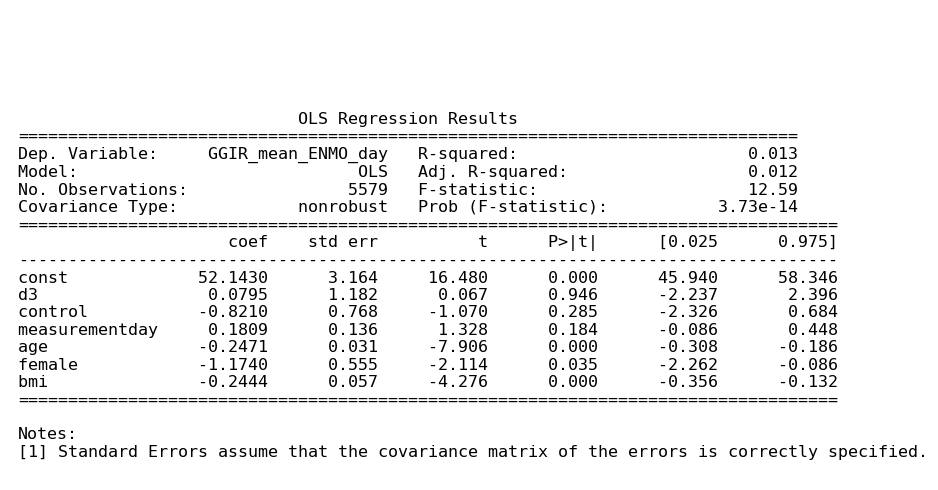

In [165]:
XVar = df[["d3", "control", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day - Osteoarthritis')

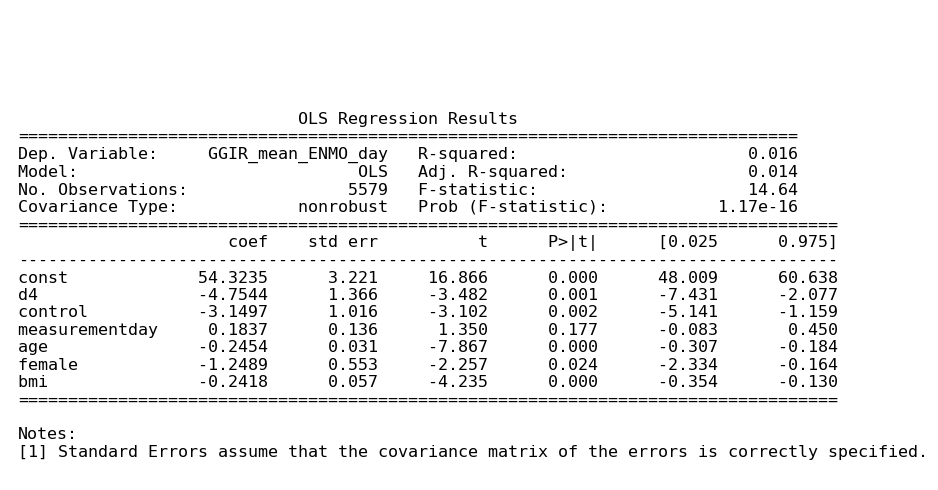

In [166]:
XVar = df[["d4", "control", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day - Hypertension&Diabetes')

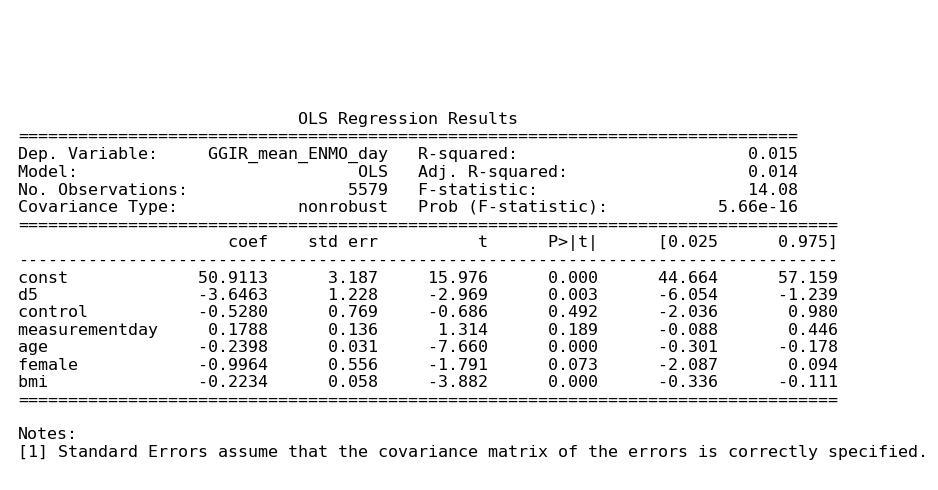

In [167]:
XVar = df[["d5", "control", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day - Hypertension&OA')

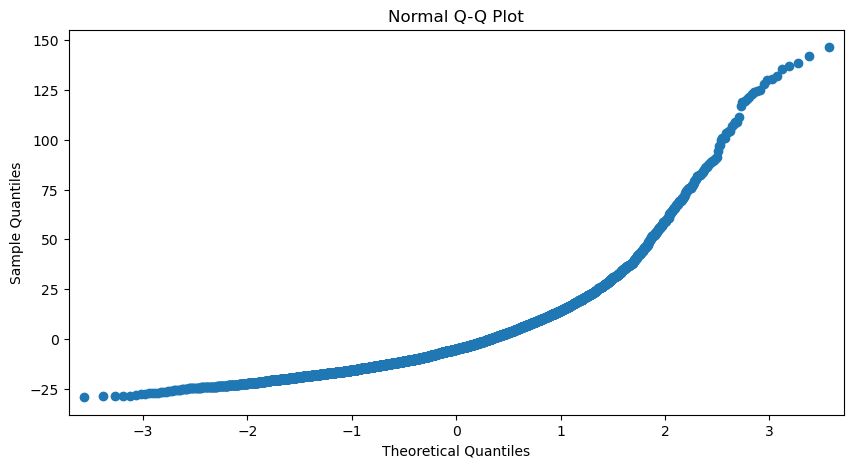

In [168]:
residuals = model.resid
sm.qqplot(residuals)
plt.title("Normal Q-Q Plot")
plt.show()

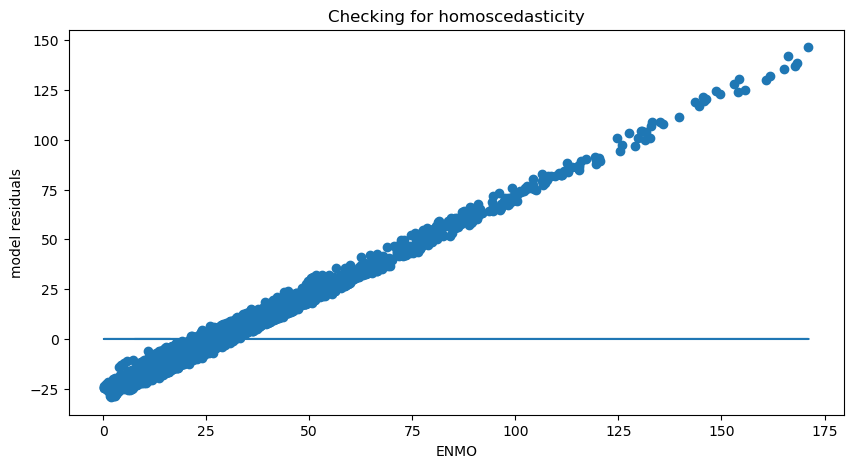

In [169]:
plt.scatter(YVar, residuals)
plt.xlabel("ENMO")
plt.ylabel("model residuals")
plt.title("Checking for homoscedasticity")
plt.plot(YVar, [0]*len(YVar))

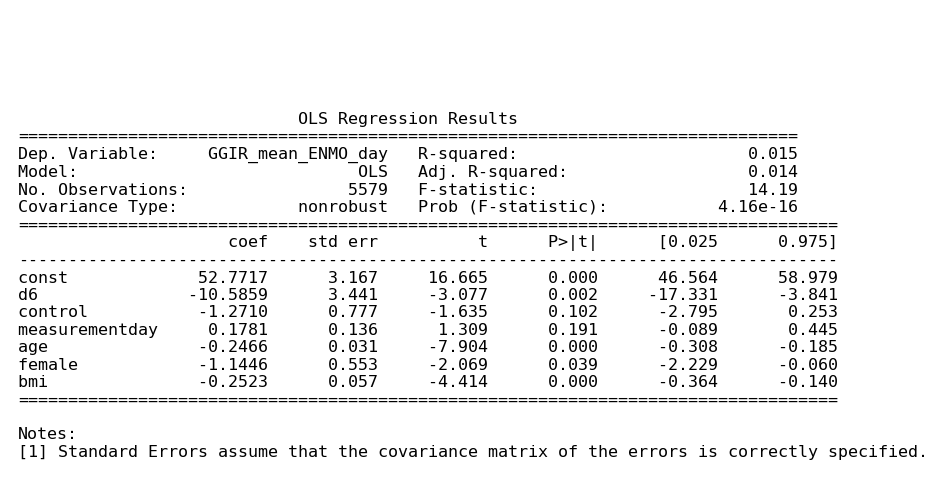

In [170]:
XVar = df[["d6", "control", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day - Diabetes&OA')

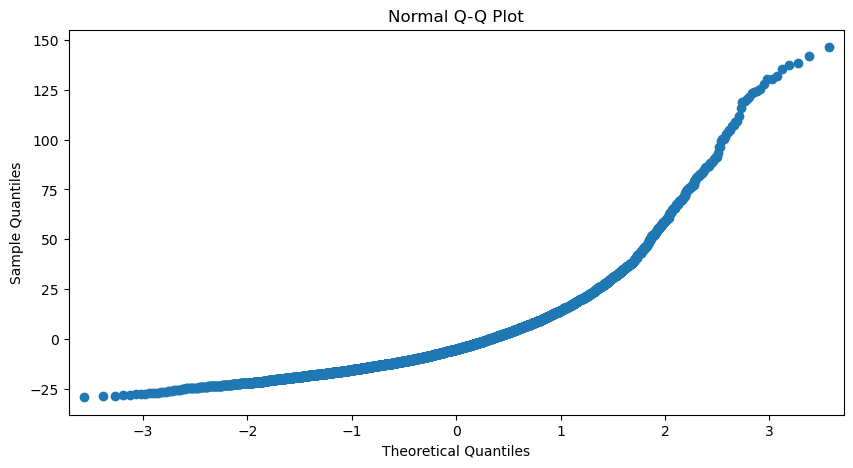

In [171]:
residuals = model.resid
sm.qqplot(residuals)
plt.title("Normal Q-Q Plot")
plt.show()

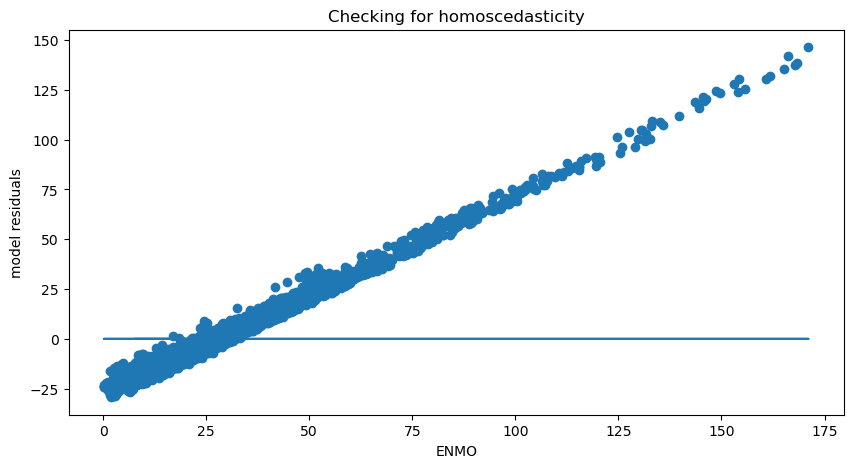

In [172]:
plt.scatter(YVar, residuals)
plt.xlabel("ENMO")
plt.ylabel("model residuals")
plt.title("Checking for homoscedasticity")
plt.plot(YVar, [0]*len(YVar))

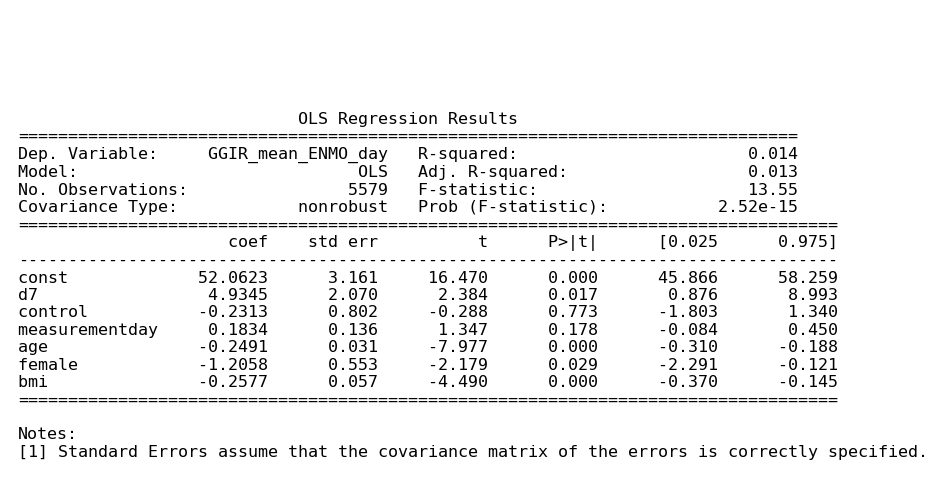

In [173]:
XVar = df[["d7", "control", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day - Hypertension&Diabetes&OA')

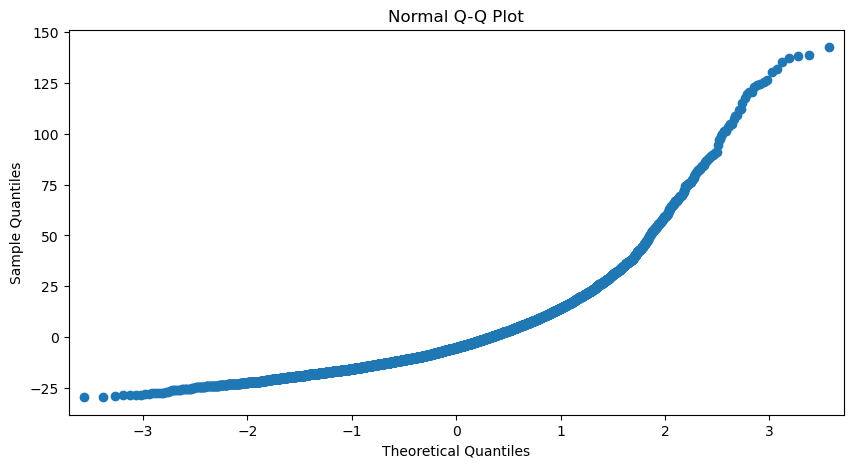

In [174]:
residuals = model.resid
sm.qqplot(residuals)
plt.title("Normal Q-Q Plot")
plt.show()

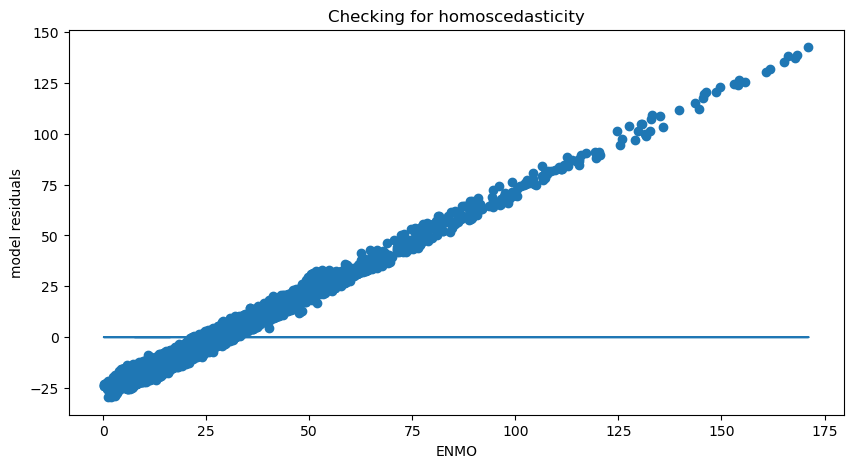

In [175]:
plt.scatter(YVar, residuals)
plt.xlabel("ENMO")
plt.ylabel("model residuals")
plt.title("Checking for homoscedasticity")
plt.plot(YVar, [0]*len(YVar))

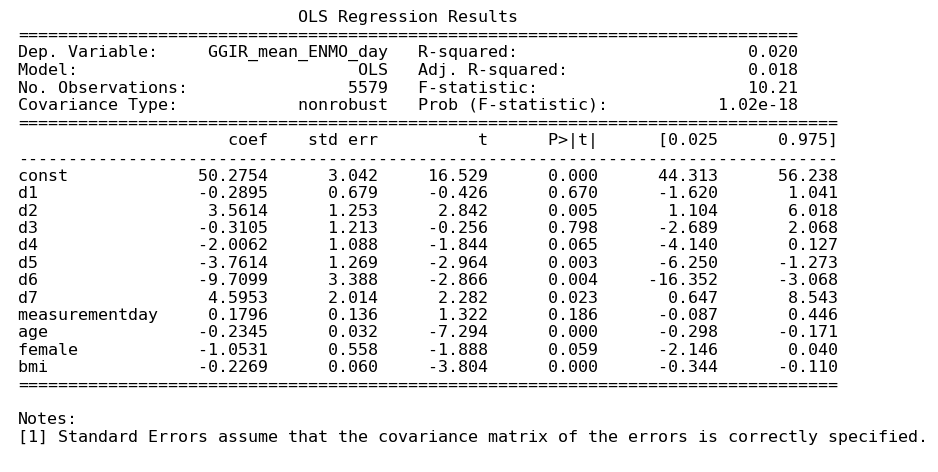

In [176]:
XVar = df[["d1","d2","d3","d4","d5","d6","d7", "measurementday", "age", "female", "bmi"]] #independent
XVar1 = sm.add_constant(XVar)
model = sm.OLS(YVar, XVar1).fit()
#print(model.summary(slim=True))

plt.rc('figure', figsize=(10, 5))
plt.text(0.01, 0.05, str(model.summary(slim=True)), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{dir_plots} Regression ENMO day')

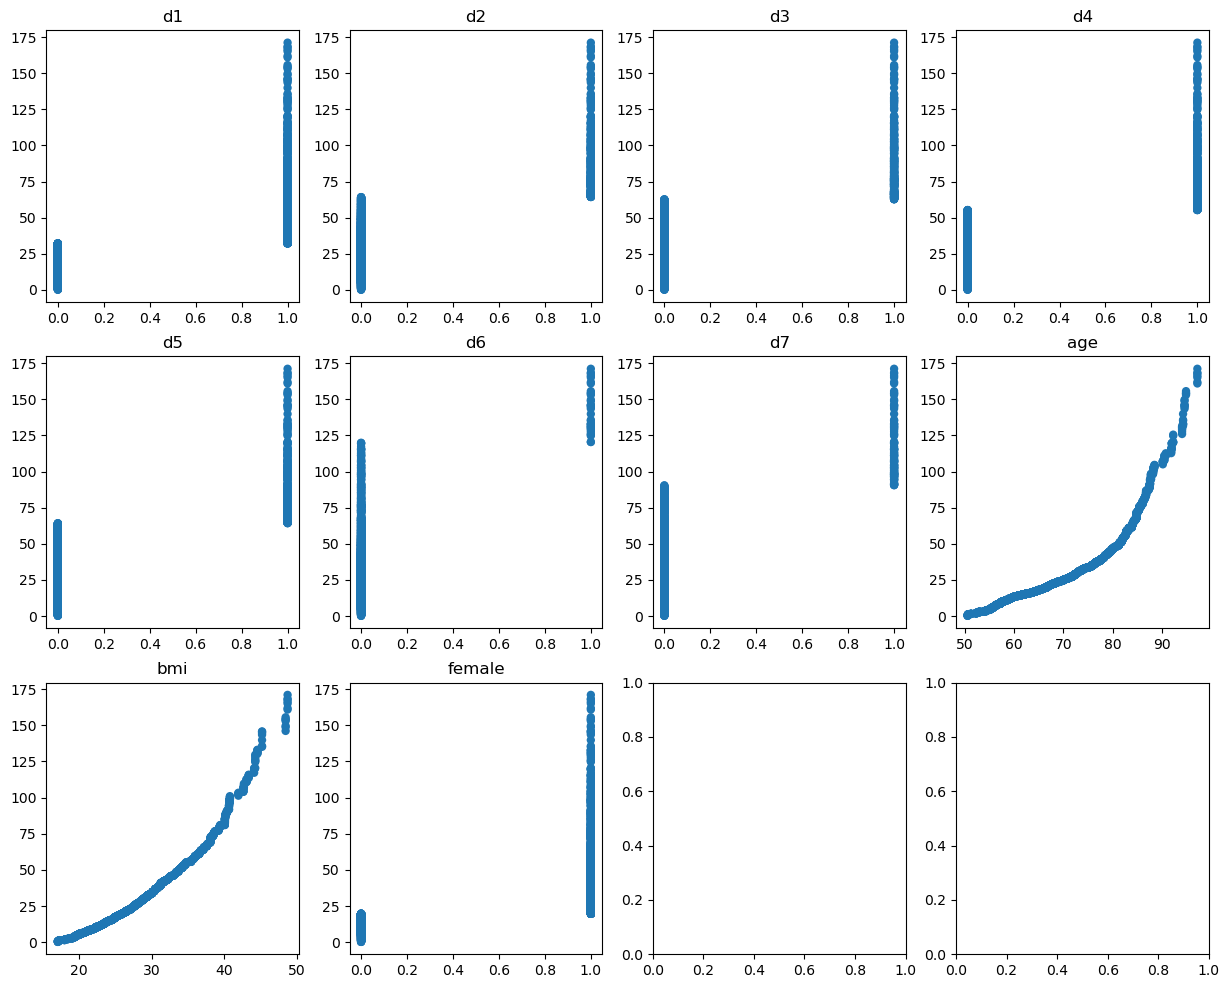

In [177]:
fig, ax = plt.subplots(3, 4, figsize=(15,12))
qqplot(df['d1'],YVar, ax=ax[0,0])
ax[0,0].set_title("d1")
qqplot(df['d2'],YVar, ax=ax[0,1])
ax[0,1].set_title("d2")
qqplot(df['d3'],YVar, ax=ax[0,2])
ax[0,2].set_title("d3")
qqplot(df['d4'],YVar, ax=ax[0,3])
ax[0,3].set_title("d4")
qqplot(df['d5'],YVar, ax=ax[1,0])
ax[1,0].set_title("d5")
qqplot(df['d6'],YVar, ax=ax[1,1])
ax[1,1].set_title("d6")
qqplot(df['d7'],YVar, ax=ax[1,2])
ax[1,2].set_title("d7")
qqplot(df["age"],YVar, ax=ax[1,3])
ax[1,3].set_title("age")
qqplot(df['bmi'],YVar, ax=ax[2,0])
ax[2,0].set_title("bmi")
qqplot(df['female'],YVar, ax=ax[2,1])
ax[2,1].set_title("female")
plt.savefig(f'{dir_plots} Linear Assumtion')

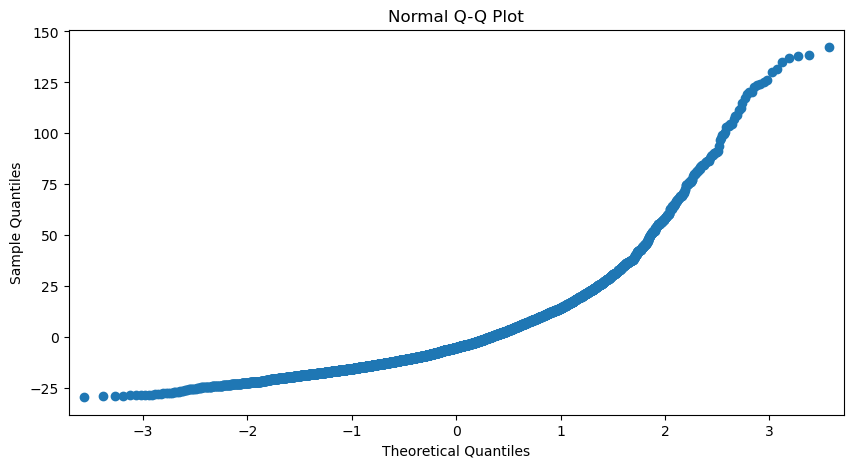

In [178]:
residuals = model.resid
sm.qqplot(residuals)
plt.title("Normal Q-Q Plot")
plt.show()

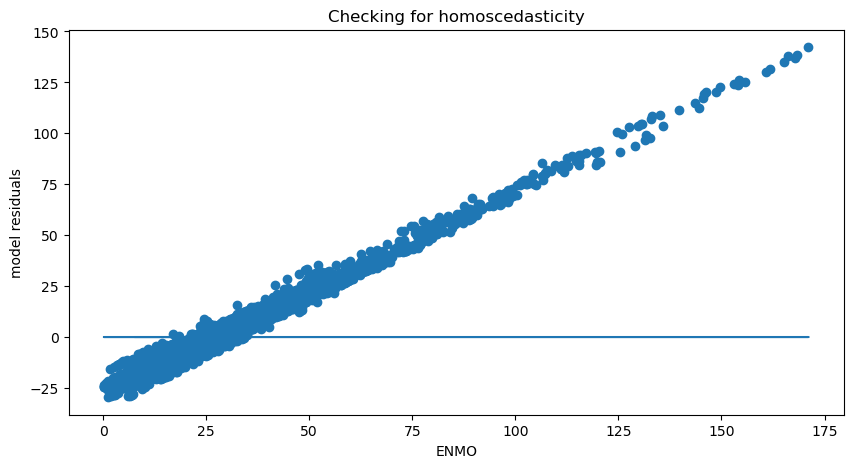

In [179]:
plt.scatter(YVar, residuals)
plt.xlabel("ENMO")
plt.ylabel("model residuals")
plt.title("Checking for homoscedasticity")
plt.plot(YVar, [0]*len(YVar))

In [180]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(XVar1.values, i) for i in range(XVar1.shape[1])]
vif["features"] = XVar1.columns
vif.round(1)

,VIF Factor,features
0,127.1,const
1,1.3,d1
2,1.1,d2
3,1.1,d3
4,1.2,d4
5,1.1,d5
6,1.0,d6
7,1.1,d7
8,1.0,measurementday
9,1.1,age


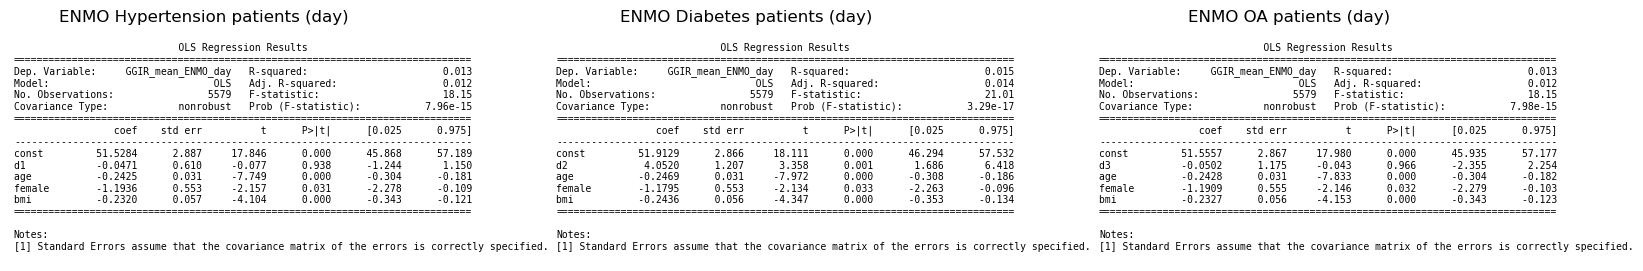

In [181]:
group = ["Hypertension", "Diabetes", "OA"]

YVar = df["GGIR_mean_ENMO_day"]

XVar1 = df[["d1", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df[["d2", "age", "female", "bmi"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df[["d3", "age", "female", "bmi"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 3))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary(slim=True)), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO {group[i]} patients (day)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
#plt.savefig(f'{dir_plots} Reg_ENMO_day (d1-d3)')

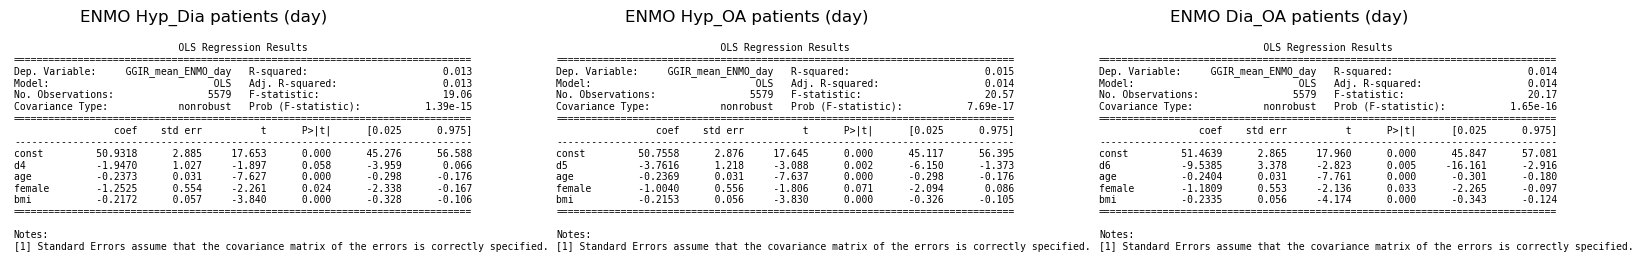

In [182]:
group = ["Hyp_Dia", "Hyp_OA", "Dia_OA"]

YVar = df["GGIR_mean_ENMO_day"]

XVar1 = df[["d4", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df[["d5", "age", "female", "bmi"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df[["d6", "age", "female", "bmi"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 3))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary(slim=True)), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO {group[i]} patients (day)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
#plt.savefig(f'{dir_plots} Reg_ENMO_day (d4-d6)')

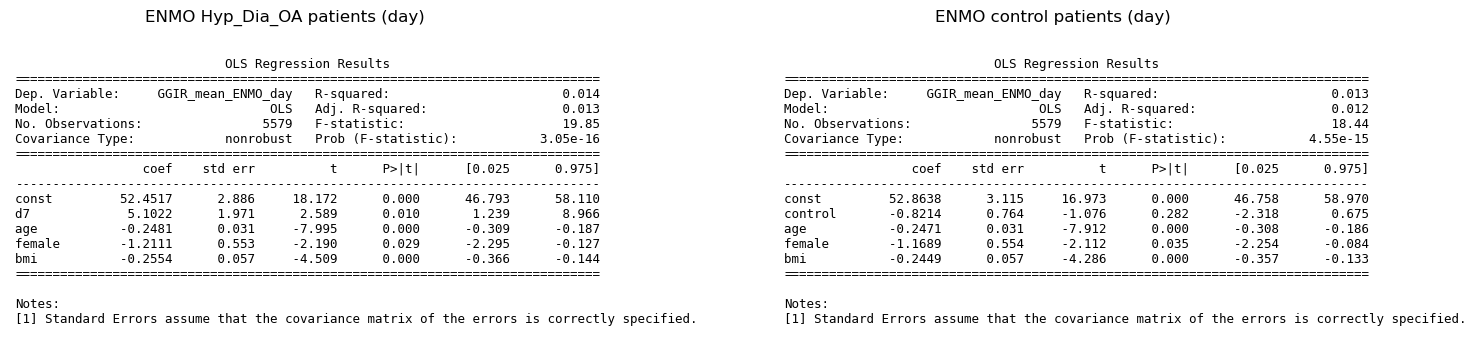

In [183]:
group = ["Hyp_Dia_OA", "control"]

YVar = df["GGIR_mean_ENMO_day"]

XVar1 = df[["d7", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df[["control", "age", "female", "bmi"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 4))
for i in [0,1]:
    ax[i].text(0.01, 0.05, str(models[i].summary(slim=True)), {'fontsize': 9}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO {group[i]} patients (day)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
#plt.savefig(f'{dir_plots} Reg_ENMO_day (d7, control)')